In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

%matplotlib inline

In [3]:
df = pd.read_csv('datasets/mlb_2013-2016.csv')
df.head()

,Season,Team,Team Salary,Team Salary (in millions),League,Wins,Losses,Winning %,AB,R,...,INN,TC,PO,A,E,DP,SBPCT,C_WP,FPCT,DER
0,2016,Arizona Diamondbacks,103372186,103.4,NL,69,93,0.426,5665,752,...,13062,6118,4354,1663,101,143,0.643,69,0.983,0.667
1,2016,Atlanta Braves,122438633,122.4,NL,68,93,0.422,5514,649,...,13029,6009,4343,1565,101,134,0.841,83,0.983,0.694
2,2016,Baltimore Orioles,157201852,157.2,AL,89,73,0.549,5524,744,...,12888,5955,4296,1579,80,165,0.651,59,0.987,0.689
3,2016,Boston Red Sox,215316336,215.3,AL,93,69,0.574,5670,878,...,12957,5821,4319,1427,75,139,0.641,52,0.987,0.695
4,2016,Chicago Cubs,182235728,182.2,NL,103,58,0.640,5503,808,...,13137,6115,4379,1635,101,116,0.778,80,0.983,0.731


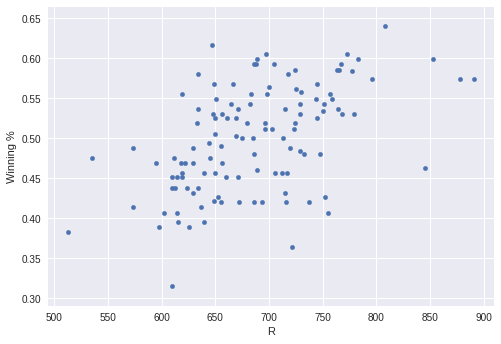

In [44]:
df.plot(kind='scatter', x='R', y='Winning %')

In [15]:
import seaborn as sns

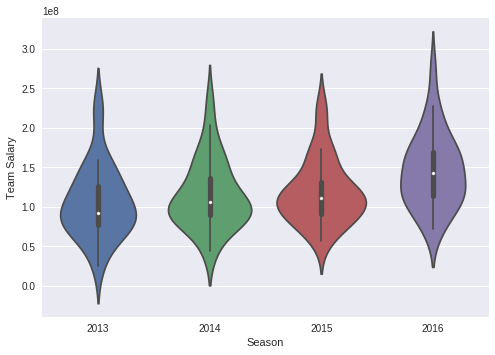

In [16]:
# df.plot(kind='scatter', x='Season', y='Team Salary')
sns.violinplot(x='Season', y='Team Salary', data=df)

In [17]:
df.columns

Index(['Season', 'Team', 'Team Salary', 'Team Salary (in millions)', 'League',
       'Wins', 'Losses', 'Winning %', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI',
       'BB', 'SO', 'SB', 'CS', 'AVG', 'OBP', 'SLG', 'OPS', 'ERA', 'SV', 'SVO',
       'IP', 'Hit Allowed', 'Runs Allowed', 'ER Allowed', 'HR Allowed',
       'BB Allowed', 'SO Pitched', 'AVG Allowed', 'WHIP', 'INN', 'TC', 'PO',
       'A', 'E', 'DP', 'SBPCT', 'C_WP', 'FPCT', 'DER'],
      dtype='object')

In [107]:
# Let's predict 'Winning %' from the rest of the columns.
cols = list(df.columns)
cols.remove('Season')
cols.remove('Team')
cols.remove('Team Salary (in millions)')
cols.remove('League')
cols.remove('Wins')
cols.remove('Losses')

banned = ['Winning %', 'Wins', 'Losses']
y_cols = ['Winning %']
feat_cols = list(set(cols) - set(y_cols) - set(banned))


/home/ericmjl/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


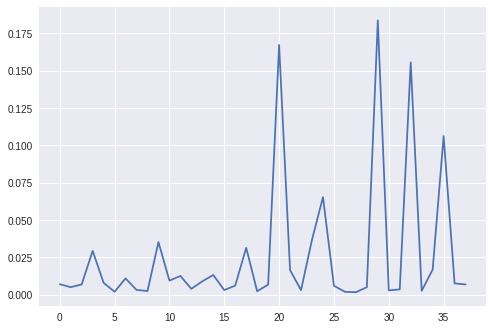

In [108]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=50)

rfr.fit(df[feat_cols], df[y_cols])
plt.plot(rfr.feature_importances_)

In [109]:
important_cols = []
threshold = 0.03
impt_idxs = [i for i, k in enumerate(rfr.feature_importances_) if k > threshold]
for i in impt_idxs:
    important_cols.append(feat_cols[i])
important_cols

['Team Salary', 'RBI', 'WHIP', 'OBP', 'R', 'AVG Allowed', 'Runs Allowed', 'SV']

In [110]:
import theano.tensor as tt
with pm.Model() as model:
    weights = pm.Normal('weights', mu=0, sd=100**2, shape=(len(important_cols),))
    perc_losses = tt.dot(weights, df[important_cols].T)
    # weights = pm.Normal('weights', mu=0, sd=100**2, shape=(2,))
    # perc_losses = weights[0] * df['Team Salary'] + weights[1] * df['R']
    alpha = 1
    beta = 1 / perc_losses
    sd = pm.HalfCauchy('sd', beta=100)
    # like = pm.Beta('likelihood', alpha=alpha, beta=beta, observed=df[y_cols])
    like = pm.Normal('likelihood', mu=perc_losses, sd=sd, observed=df[y_cols])
    # like = pm.Beta('likelihood', mu=perc_losses, sd=sd, observed=df[y_cols])
    # like = pm.Bernoulli('likelihood', p=perc_losses, observed=df[y_cols])

In [111]:
with model:
    trace = pm.sample(50000, step=pm.Metropolis())

100%|██████████| 50000/50000 [00:16<00:00, 2994.89it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fadf3f852e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fadd6c2d2b0>]], dtype=object)

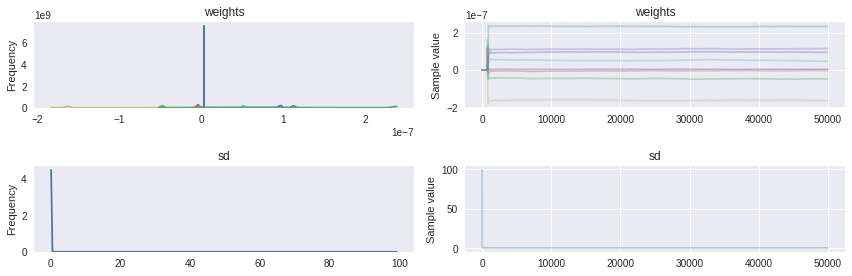

In [112]:
pm.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fadd6b29d68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fadd69e9358>]], dtype=object)

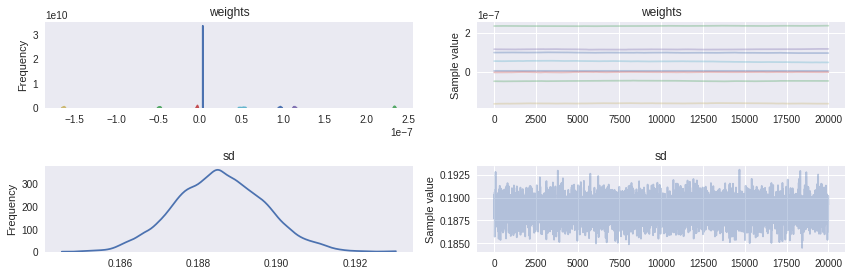

In [113]:
burnin = 30000
pm.traceplot(trace[burnin:])